In [74]:
import artm
import glob
import os

source_file = os.path.join("reviews_tv//wv_tvs")
batches_folder = os.path.join("reviews_tv//tvs")

if not glob.glob(os.path.join(batches_folder, "*")):
    batch_vectorizer = artm.BatchVectorizer(data_path=source_file, 
                                            data_format="vowpal_wabbit", 
                                            target_folder=batches_folder,
                                            batch_size=100)
else:
    batch_vectorizer = artm.BatchVectorizer(data_path=batches_folder,
                                            data_format='batches')

# Creating the dictionary (don't forget to save in ascii format the wv_tvs!)

In [75]:
dict_name = os.path.join(batches_folder, "dict_tvs.txt")
dictionary = artm.Dictionary(name="dictionary")
i = 0
if not os.path.exists(dict_name):
    dictionary.gather(batches_folder)
    print (i)
    dictionary.save_text(dict_name)
    i+=1
else:
    dictionary.load_text(dict_name)

0


In [76]:
scores_list = []
scores_list.append(artm.PerplexityScore(name='PerplexityScore'))  # перплексия (перенормированное правдоподобие)
scores_list.append(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="@words"))   # разреженность Phi
scores_list.append(artm.SparsityThetaScore(name='SparsityThetaScore'))   # разреженность Theta
scores_list.append(artm.TopTokensScore(name="top_words", 
                                          num_tokens=10, 
                                          class_id="@words"))  # для печати наиболее вероятных терминов темы

# Put some weight on other parameters rather than texts: # of votes, metrics scores

In [77]:
modals = ["@words", "@category", "@votes", "@metrics"]
T = 20   # количество тем
model_artm = artm.ARTM(num_topics=T,  # число тем
                       class_ids={"@words":1, "@sku":1, "@votes":5, "@metrics":3},   # число после названия модальностей - это их веса
                       num_document_passes=10,   # сколько делать проходов по документу
                       cache_theta=True,   # хранить или нет глоабльную матрицу Theta
                       reuse_theta=False,   # если Theta хранится, нужно ли ее вновь инициализировать при каждом проходе
                       theta_columns_naming="title",   # как именовать столбцы в матрице Theta
                       seed=789)   # random seed
#                        scores=scores_list)  # метрики качества

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
for mod in modals:
    model_artm.scores.add(artm.TopTokensScore(name="top_"+mod[1:], 
                                              num_tokens=10, 
                                              class_id=mod))

In [78]:
model_artm.initialize(dictionary)
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, \
                             num_collection_passes=20)

Wall time: 18.5 s


In [79]:
from matplotlib import pyplot as plt
# %matplotlib inline
# import seaborn

# plt.plot(model_artm.score_tracker["PerplexityScore"].value[1:])

In [80]:
print ("Perplexity:", model_artm.score_tracker["PerplexityScore"].last_value)

print ("Phi sparsity:",model_artm.score_tracker["SparsityPhiScore"].last_value)
print ("Theta sparsity:", model_artm.score_tracker["SparsityThetaScore"].last_value)
print ("Topic kernel score: ", model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

Perplexity: 73.61080953386595
Phi sparsity: nan
Theta sparsity: 0.014921100213686922
Topic kernel score:  0.0


In [81]:
# topics without regulazers
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    print (", ".join(model_artm.score_tracker["top_words"].last_tokens[topic_name]))

topic_0: 
samsung, picture, hub, wall, experience, mount, use, qled, wall_mount, come
topic_1: 
purchase, television, picture, quality, samsung, far, new, t.v, sound, value
topic_2: 
color, picture, look, screen, black, light, use, connect, remote, motion
topic_3: 
return, vizio, screen, buy, walmart, day, box, tell, store, turn
topic_4: 
4_k, samsung, value, brand, definitely, feel, quality, look, picture, suhd
topic_5: 
samsung, new, size, use, large, screen, color, purchase, display, big
topic_6: 
remote, watch, look, movie, color, control, use, room, screen, button
topic_7: 
app, netflix, unit, start, week, internet, update, service, stream, try
topic_8: 
picture, set, use, sony, samsung, new, adjustment, buy, purchase, think
topic_9: 
connect, cable, turn, use, device, input, plug, box, hdmi, cable_box
topic_10: 
sound, speaker, use, picture, sound_bar, quality, overall, audio, need, volume
topic_11: 
picture, samsung, set, use, quality, sound, purchase, look, color, come
topic_12

In [82]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=-0.25, 
                                                            dictionary="dictionary",
                                                            class_ids=["@words"]), overwrite = True)
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', 
                                                            tau=-0.25), overwrite = True)
#                                                             class_ids=["@words"]))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+1), overwrite = True)

In [83]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, 
                       num_collection_passes=15)

In [84]:
print ("Phi sparsity:",model_artm.score_tracker["SparsityPhiScore"].last_value)
print ("Theta sparsity:", model_artm.score_tracker["SparsityThetaScore"].last_value)

print ("Perplexity:", model_artm.score_tracker["PerplexityScore"].last_value)

print ("Topic kernel score: ", model_artm.score_tracker['TopicKernelScore'].last_average_purity)

Phi sparsity: nan
Theta sparsity: 0.7766040216974412
Perplexity: 72.58215228063402
Topic kernel score:  0.0


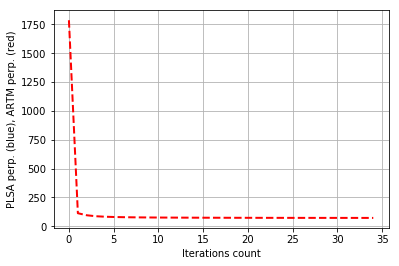

In [85]:
def print_measures(model_artm):

    plt.plot(
#         xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_artm)

In [86]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    print (", ".join(model_artm.score_tracker["top_words"].last_tokens[topic_name]))

topic_0: 
samsung, picture, wall, mount, set, hub, use, experience, wall_mount, connect
topic_1: 
television, picture, purchase, samsung, quality, product, sound, new, buy, t.v
topic_2: 
color, picture, look, screen, light, black, remote, setting, motion, image
topic_3: 
return, vizio, screen, buy, walmart, purchase, day, turn, box, time
topic_4: 
4_k, samsung, picture, value, look, definitely, uhd, brand, model, suhd
topic_5: 
samsung, new, size, purchase, old, screen, year, use, color, large
topic_6: 
remote, watch, movie, control, color, use, look, screen, button, room
topic_7: 
app, netflix, unit, internet, apps, stream, update, access, service, start
topic_8: 
picture, set, samsung, use, buy, new, purchase, sony, look, sound
topic_9: 
connect, cable, turn, device, use, box, connection, input, hdmi, plug
topic_10: 
sound, speaker, picture, use, sound_bar, quality, audio, volume, overall, need
topic_11: 
picture, samsung, set, quality, use, sound, purchase, look, remote, price
topic

In [87]:
model_artm.save("my_model")

In [88]:
import numpy as np
import pandas as pd

In [97]:
def print_topic(model, topic_name):
    
    intermediate_directory = 'C:\\Users\\liliya.akhtyamova\\Documents\\reviews\\full_reviews\\pwr\\36rrc4k3\\rawdata'
    review_txt_filepath = os.path.join(intermediate_directory,
                                   'data_tv_for_wv.txt')
    theta = model.get_theta()
    docs = theta.ix[topic_name].sort_values()[:-150:-1]
    
    print ("------", topic_name, "------")
    print ("Top words:", " ".join(model.score_tracker["top_words"].last_tokens[topic_name][:15]))
    print ("Reviews")
    links = []
    thetas = []
    for link in docs.index:
        for theta in docs:
#             print (theta)
            if link not in links:
                links.append(link)
                thetas.append(theta)
#     print (thetas)
    c = sorted(zip(thetas, links), reverse = True)  
#     print (c)
    for theta, link in c:
        print ("*", link,)
        reviews = []
        model = []
        item = []
        for el in open(review_txt_filepath):
            if link == el.split('; ')[2]:
                if el.split('; ')[5] not in reviews:
                    reviews.append(el.split('; ')[5])
                    model.append(el.split('; ')[1])
                    item.append(el.split('; ')[0])
        print ('review: \n', reviews)
        print ('model: \n', model)
        print ('theta: ', theta)
        print ()
        print ('item: ', item)
        print ()

In [98]:
print_topic(model_artm, model_artm.topic_names[8])

C:\Users\liliya.akhtyamova\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


------ topic_8 ------
Top words: picture set samsung use buy new purchase sony look sound
Reviews
* 98830863
review: 
 ['Replaced My Dual Failing 22" LCD\'s. Has Great Contrast easy on the eyes and plenty real estate for multi-applications\n']
model: 
 ['Proscan PLDED3281 32" 1080p 60Hz LED HDTV']
theta:  1.0

item:  ['8561c29245dc4636857f9ce748301afd']

* 98780667
review: 
 ['Beautiful picture on this tv. Was shipped directly to my home. Great tv for the price!\n']
model: 
 ['Samsung UN55KU6290 - 55-Inch Smart 4K UHD HDR LED TV']
theta:  1.0

item:  ['073bdbc7dd0f432ba1fe39f36c97fdd0']

* 98403694
review: 
 ["Once you get past set up it's perfect best if you use a fire stick!\n"]
model: 
 ['VIZIO 60 Inch 4K Ultra HD Smart TV w/Chromecast Built-In E60-E3 (2017 Model)']
theta:  1.0

item:  ['a335f31740aa4fe0bb4b75eec33c89ad']

* 98380623
review: 
 ['With curved technology, you can watch the picture from two corners of the room clearly.\n']
model: 
 ['Samsung UN55K6250 - Curved 55-Inch 1

In [99]:
intermediate_directory = 'C:\\Users\\liliya.akhtyamova\\Documents\\reviews\\full_reviews\\pwr\\36rrc4k3\\rawdata'
review_txt_filepath = os.path.join(intermediate_directory,
                                   'data_tv_partial.txt')
items_phi = model_artm.get_phi(class_ids=["@sku"])

In [100]:
items_topics = items_phi.values
items_topics /= items_topics.sum(axis=1)[:, np.newaxis]

In [101]:
items_corr = pd.DataFrame(data=np.corrcoef(items_topics),
                            index=items_phi.index,
                            columns=items_phi.index)

In [102]:
items_corr.head()

,14a6ffa08554499cbd09ab87bc424404,8a5d00482fca4619a8eafda3b9ba5784,0000439826a645f09f4d09b7a4c53e4f,8de54be14af84de1a2033ad768a61dc1,cd70ff175d864065bfee7b6faa08f29b,73c4244b761e4465ad64064ec6f38d80,244cbfa49d4e47bbb04ea0dc35bb7b90,f061d2b5e80a46f081fa1e16f6c9522e,20197fbe19134d6d871e7553fda2e1d4,c5850ceb9c314f499ae5cfa7aabb70a4,...,f520f4d09afc4943bb4d3a3b650067f6,f641450162604b5d8329b28277f19e17,f99a3e8275b24244bc31bd3c4295b3b8,f9fa6c828f0042028eeb31754354f98f,fa460d2253674226a6c86f89a33bdaad,fbece9ffe61b45de81b95498a13ca419,fd064b9bea904415a0122830e1c57418,fd788c8110d24c9cb3b5d33264a1fd14,feed08a0427b4401880dc47803e54897,fef4a0c1eb6c45179415ddc9fa46cf5e
14a6ffa08554499cbd09ab87bc424404,1.000000,0.763210,-0.149849,-0.077868,-0.091363,-0.117082,-0.171057,-0.077872,-0.077872,-0.098162,...,-0.086029,-0.087080,-0.041745,-0.110462,-0.077872,0.022164,-0.077872,-0.108791,-0.077872,-0.104771
8a5d00482fca4619a8eafda3b9ba5784,0.763210,1.000000,-0.062142,-0.059411,-0.069705,-0.089352,-0.027716,-0.059413,-0.059413,-0.074892,...,-0.066929,-0.072361,-0.059413,-0.084277,-0.059413,-0.142883,-0.059413,-0.083003,-0.059413,-0.087229
0000439826a645f09f4d09b7a4c53e4f,-0.149849,-0.062142,1.000000,-0.101279,-0.118825,-0.152316,0.078165,-0.101279,-0.101279,0.061176,...,-0.114092,-0.123352,-0.101279,-0.143665,-0.101279,-0.067546,-0.101279,-0.141494,0.555527,0.316396
8de54be14af84de1a2033ad768a61dc1,-0.077868,-0.059411,-0.101279,1.000000,-0.061749,-0.079154,-0.112255,-0.052632,-0.052632,-0.066345,...,-0.059290,-0.064102,-0.052632,-0.074658,-0.052632,-0.175691,-0.052632,0.462339,-0.052632,-0.077273
cd70ff175d864065bfee7b6faa08f29b,-0.091363,-0.069705,-0.118825,-0.061749,1.000000,-0.018722,-0.081696,0.014699,-0.061749,0.948349,...,0.007091,-0.075207,-0.061749,0.817780,0.042158,-0.182147,0.992883,-0.086264,-0.061749,0.695839


In [107]:
corr = items_corr[u"d9e290893621458cb917d1200e21a150"].sort_values()[:-50:-1]
print (corr)

d9e290893621458cb917d1200e21a150    1.000000
fd1843455aa747d5be3b9715b8691960    0.976963
f99a3e8275b24244bc31bd3c4295b3b8    0.964509
f34b3651b2114b4b83aea0400ff273ea    0.964509
55b853370aa9436ebcb9bb562e2019a1    0.964508
4864b35295994c0f8aabe727e11fef7a    0.964508
636129115fb84877928f8341bebc0ad3    0.964508
0cec6825f7854fbfb1802a9da96ab464    0.964272
f6b81681a65f41d7a5481a88610bf37f    0.961747
2a02c526d31c4859b25641d8db7fc80b    0.959740
ae56e7d94c4247be84ee091ee83b1733    0.939533
beb77232be38411d90674958a26d42b3    0.558469
e1f99d113a084ddf9bae07c60bb63b7a    0.492962
61bf5e7d76f648aa9ed89621ab8e3020    0.446705
89b03a99385c4c119d01ca7226d43a3e    0.442679
966f4cf0279147ed89bff9a0bbe78d8d    0.423460
3212f1a92d704321a42cf0385d51d6ca    0.405207
27ca16cf9d9d4c59abfa031a9fdd19e1    0.391419
a0834aba91334838b44d9549d16cf574    0.385254
a0226a406b73499f8579e91a5853f502    0.301507
f520f4d09afc4943bb4d3a3b650067f6    0.204816
73c4244b761e4465ad64064ec6f38d80    0.185913
5f74e18fe1

# Print correlated skus only on the items which have more than 30 reviews

In [109]:
intermediate_directory = 'reviews_tv'
review_txt_filepath = os.path.join(intermediate_directory,
                               'data_tv_partial.txt')
for ind in range(18):
    i = 0
    for el in open(review_txt_filepath):
       

    #         print (index)
        if corr.index[ind+1] in el.split('; ')[0]:
            i+=1
    if i>30:
        print (i)
        print (corr.iloc[ind+1:ind+2])

282
fd1843455aa747d5be3b9715b8691960    0.976963
Name: d9e290893621458cb917d1200e21a150, dtype: float64
65
ae56e7d94c4247be84ee091ee83b1733    0.939533
Name: d9e290893621458cb917d1200e21a150, dtype: float64
272
e1f99d113a084ddf9bae07c60bb63b7a    0.492962
Name: d9e290893621458cb917d1200e21a150, dtype: float64
194
61bf5e7d76f648aa9ed89621ab8e3020    0.446705
Name: d9e290893621458cb917d1200e21a150, dtype: float64
624
89b03a99385c4c119d01ca7226d43a3e    0.442679
Name: d9e290893621458cb917d1200e21a150, dtype: float64
624
966f4cf0279147ed89bff9a0bbe78d8d    0.42346
Name: d9e290893621458cb917d1200e21a150, dtype: float64
194
3212f1a92d704321a42cf0385d51d6ca    0.405207
Name: d9e290893621458cb917d1200e21a150, dtype: float64


In [5]:
# i=0
# for el in open(review_txt_filepath):
#     if '823fbb41b264471cbe41c5adbcdeb932' in el.split('; ')[0].lower():
#         i+=1
#         print (el.split('; ')[5])
# print (i)

Netflix, sports, CNN, weekly shows everything looks absolutely great.

Best tv I've ever owned ! Simple to install and set up ! Awesome graphics

This new TV is out of this world. Color settings can be a hassle to get it how you want it. I just googled the model and color setup and found some great options. Yours may vary. I went from a 720p older TV and this TV blows it out of the water. I see many more vibrant colors when viewing movies and playing on the PS4. Great TV. I hope it lasts for many many many years.

This product has been very useful in my household we watch lots of TV and this makes it all that. A little tipsy but good Without wall mount

I've been holding out for a quality smart tv for quite some time. After doing my homework I settled on the Samsung 43" UHDTV. The SmartHub, built in WiFi, quad core processor and 120 motion rate are just a few features that make this a great television at a reasonable price.

This is a great TV for prize. It provides the basic 4K UHD TV